In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

from scipy.linalg import eigh, norm
from scipy.sparse.linalg import expm_multiply
from scipy.fft import fft2
from scipy.integrate import dblquad
from tqdm import tqdm

# Functions

In [2]:
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
def time_evol(H,tstart=0,tstop=1,Num=100,N_em=1,psi=[1.]):
    
    n = np.shape(H)[0]-N_em
    psi_in = np.array([0.]*n + psi)

    temp = expm_multiply(-1.j*H,psi_in,tstart,tstop,Num)
    
    return temp[:,-1], temp[:,:-1]

In [4]:
def HamPBC(N,J=1):
    dk = 2*np.pi/(N+2)
    k = np.linspace(-np.pi,np.pi-dk,N+2) - np.pi
    kx, ky = np.meshgrid(k,k)

    A = np.diag(np.ravel(2 - 2*np.cos(ky)))
    C = np.diag(np.ravel(2 - 2*np.cos(kx)))
    B = -np.diag((1- np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))
    A2 = np.roll(fft2(A/(N+2)**2)[::-1],1,axis=0)
    C2 = np.roll(fft2(C/(N+2)**2)[::-1],1,axis=0)
    B2 = np.roll(fft2(B/(N+2)**2)[::-1],1,axis=0)
    
    mask = np.ones(((N+2)**2,(N+2)**2),dtype="bool")
    mask[:N+2,:] = mask[(N+2)*(N+1):,:] = False
    mask[:,:N+2] = mask[:,(N+2)*(N+1):] = False
    mask[::N+2,:] = mask[:,::N+2] = False
    mask[N+1::N+2,:] = mask[:,N+1::N+2] = False

    A2 = A2[mask].reshape(N**2,N**2)
    B2 = B2[mask].reshape(N**2,N**2)
    C2 = C2[mask].reshape(N**2,N**2)
    
    A2 += np.diag(([-J]+[0]*(N-1))*(N-1)+[-J],k=N-1)
    A2 += np.diag(([-J]+[0]*(N-1))*(N-1)+[-J],k=1-N)
    C2 += np.diag([-J]*N,k=N*(N-1))
    C2 += np.diag([-J]*N,k=-N*(N-1))
    B2 += np.diag([J]*N,k=N*(N-1))
    B2 += np.diag([0]+[-J]*(N-1)+[0],k=N*(N-1)-1)
    B2 += np.diag([0]*(N-1)+([-J]+[0]*(N-1))*(N-1),k=-1)
    B2 += np.diag(([J]+[0]*(N-1))*(N-1)+[J],k=N-1)
    
    H = np.block([
        [A2,B2],
        [np.transpose(np.conjugate(B2)),C2]
    ])

    H = np.real(np.round(H,0))
    H[0,-1] = -J
    H[-1,0] = -J
    
    return np.real(H)

In [5]:
def HamOBC(N,J=1):
    dk = 2*np.pi/(N+2)
    k = np.linspace(-np.pi,np.pi-dk,N+2) - np.pi
    kx, ky = np.meshgrid(k,k)

    A = np.diag(J*np.ravel(2 - 2*np.cos(ky)))
    C = np.diag(J*np.ravel(2 - 2*np.cos(kx)))
    B = -np.diag(J*(1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))
    A2 = np.roll(fft2(A/(N+2)**2)[::-1],1,axis=0)
    C2 = np.roll(fft2(C/(N+2)**2)[::-1],1,axis=0)
    B2 = np.roll(fft2(B/(N+2)**2)[::-1],1,axis=0)
    
    mask = np.ones(((N+2)**2,(N+2)**2),dtype="bool")
    mask[:N+2,:] = mask[(N+2)*(N+1):,:] = False
    mask[:,:N+2] = mask[:,(N+2)*(N+1):] = False
    mask[::N+2,:] = mask[:,::N+2] = False
    mask[N+1::N+2,:] = mask[:,N+1::N+2] = False
    
    A2 = A2[mask].reshape(N**2,N**2)
    B2 = B2[mask].reshape(N**2,N**2)
    C2 = C2[mask].reshape(N**2,N**2)
    
    H = np.block([
        [A2,B2],
        [np.transpose(np.conjugate(B2)),C2]
    ])

    H = np.round(H,0)
    
    return np.real(H)

In [6]:
def HamOBC2(N,J=1):
    
    H = HamOBC(N)
    H[:N,:] = H[:,:N] = 0
    H[N**2 + N-1::N,:] = H[:,N**2 + N-1::N] = 0
    
    return H

In [7]:
def HamOBC3(N,J=1):
    
    H = HamOBC(N)
    H[:N**2:N,:] = H[:,:N**2:N] = 0
    H[N*(2*N-1):,:] = H[:,N*(2*N-1):] = 0 
    
    return H

In [8]:
def BS_fin_A(N,om,x,y):

    dk = 2*np.pi/N
    k = np.linspace(-np.pi,np.pi-dk,N)
    if N%2 == 0:
        mask = np.ones(N,dtype="bool")
        mask[N//2] = False
        k = k[mask]
        I = 0
        res = 1/(om * N**2)
        for kk in k:
            res += ((1-np.cos(kk))/(1-np.cos(kk)) * np.exp(1.j*kk*y)) / (om* N**2)
            res += (1-np.cos(kk))/(1-np.cos(kk)) * (1/(om-2*(1-np.cos(kk))))*np.exp(1.j*kk*x) / N**2        
    else:
        res = 0
        I = 0
    
    kx, ky = np.meshgrid(k,k)
    
    I += ((1-np.cos(ky))/(2-np.cos(kx)-np.cos(ky)) * np.exp(1.j*(kx*x+ky*y)))/ (om* N**2)
    I += (1-np.cos(kx))/(2-np.cos(kx)-np.cos(ky)) * (1/(om-2*(2-np.cos(kx)-np.cos(ky))))*np.exp(1.j*(kx*x + ky*y)) / N**2

    return np.sum(I) + res 

BS_A = np.vectorize(BS_fin_A,excluded=["N","om"])

In [9]:
def BS_fin_B(N,om,x,y):
    
    # This is okay since every term in which one of
    # the k-components is zero yields a zero 
    # contribution
    
    dk = 2*np.pi/N
    k = np.linspace(-np.pi,np.pi-dk,N)
    if N%2 == 0:
        mask = np.ones(N,dtype="bool")
        mask[N//2] = False
        k = k[mask]
    else:
        I = 0
    
    kx, ky = np.meshgrid(k,k)
    
    I = (1-np.exp(1.j*kx))*(1-np.exp(1.j*ky))/(2*(2-np.cos(kx)-np.cos(ky))) * np.exp(1.j*(kx*x+ky*y))/om
    I -= (1-np.exp(1.j*kx))*(1-np.exp(1.j*ky))/(2*(2-np.cos(kx)-np.cos(ky))) * np.exp(1.j*(kx*x+ky*y))/(om-2*(2-np.cos(kx)-np.cos(ky)))
    I /= N**2
    
    return np.sum(I)

BS_B = np.vectorize(BS_fin_B,excluded=["N","om"])

# Emitter coupled to the Checkerboard-I model (Period BCs)

## Local coupling

It is important to distinguish between systems with odd or even number of lattice sites. This is related to the fact that the allowed values of $\vec{k}$ in the FBZ (which in this case is a square) are
\begin{equation}
    \vec{k} = -\pi,\dots,\pi\left(1 - \frac{2}{N}\right)
\end{equation}
and so the value $\vec{k} = 0$ is taken only if N is even.

### Odd number of lattice points: No Band Touching

In [10]:
N = 21
J = 1

g = 0.1
om_a = -1

We define the Hamiltonian.

In [11]:
pos = (N+1)*N//2 + N//2
coup = np.zeros((2*N**2,1))
coup[pos,0] -= g

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

We diagonalize it and plot the eigenvalues. 

In [12]:
eigval, eigvect = eigh(H)

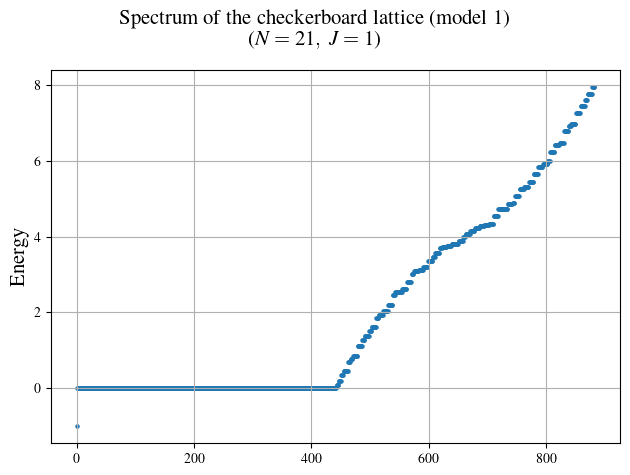

In [13]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

#plt.xlim(0,50)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

#### Atom-photon bound state

Here, we show with a contour plot the shape of the atom-photon Bound State.

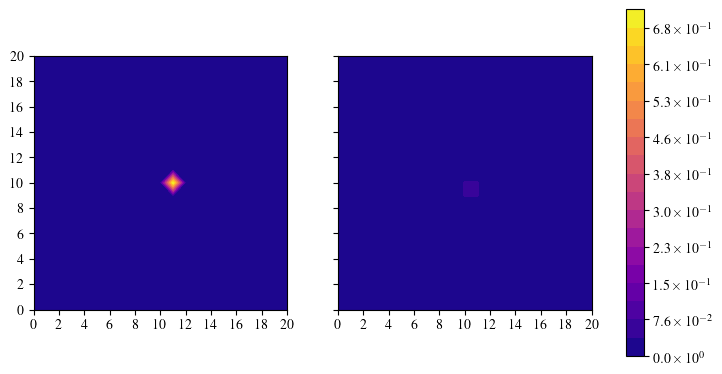

In [14]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(9,9))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateA)**2)
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA)**2,cmap="plasma",levels = np.linspace(vmin,vmax,20))
ax[1].contourf(Nx,Ny,np.abs(stateB)**2,cmap="plasma",levels = np.linspace(vmin,vmax,20))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,2))
ax[0].set_xticks(np.arange(0,N,2))
ax[1].set_xticks(np.arange(0,N,2))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

We plot sections in the two directions in order to show the behaviour.

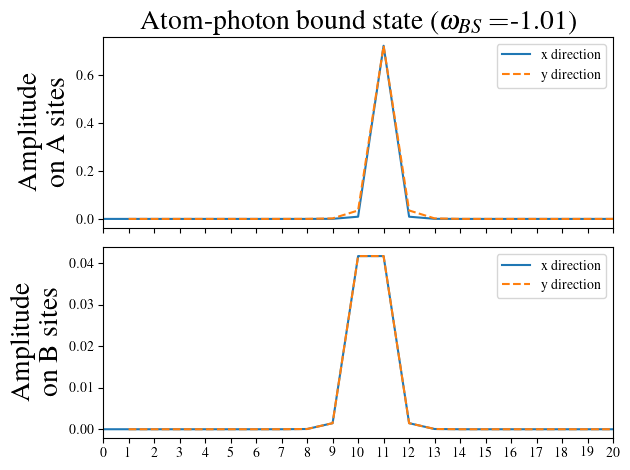

In [19]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)


ax[0].plot(np.arange(0,N,1),abs(stateA[N//2,:])**2,label="x direction")
ax[0].plot(np.arange(1,N+1,1),abs(stateA[:,N//2+1])**2,label="y direction",ls="--")

ax[1].plot(np.arange(0,N,1),abs(stateB[N//2,:])**2,label="x direction")
ax[1].plot(np.arange(1,N+1,1),abs(stateB[:,N//2+1])**2,label="y direction",ls="--")

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))

ax[0].legend()
ax[1].legend()
plt.show()

Here, we show the envelope of the bound state in $\texttt{log}$ scale

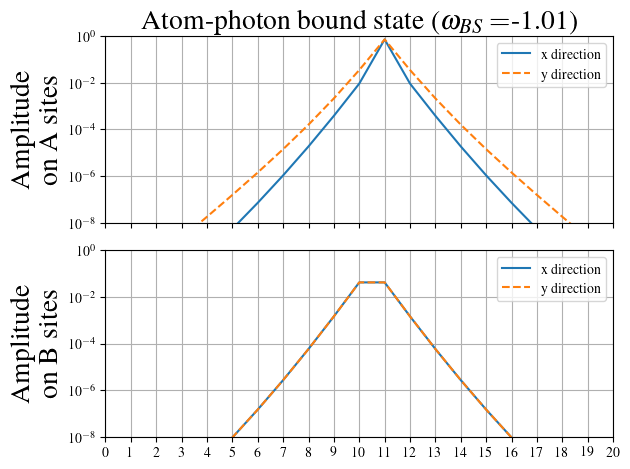

In [24]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=1,tight_layout=1)


ax[0].plot(np.arange(0,N,1),np.abs(stateA[N//2,:])**2,label="x direction")
ax[0].plot(np.arange(1,N+1,1),np.abs(stateA[:,N//2+1])**2,label="y direction",ls="--")

ax[1].plot(np.arange(0,N,1),np.abs(stateB[N//2,:])**2,label="x direction")
ax[1].plot(np.arange(1,N+1,1),np.abs(stateB[:,N//2])**2,label="y direction",ls="--")

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
ax[0].set_ylim(1e-8,1)
ax[1].set_ylim(1e-8,1)
ax[0].grid()
ax[1].grid()

ax[1].set_yscale("log")

ax[0].legend()
ax[1].legend()
#plt.savefig("eigs&spectra/bs.png")
plt.show()

Here, we compare the bound state with the analytical expectations.

In [17]:
x = np.arange(-N//2,N//2,1)
x, y = np.meshgrid(x,x)

In [18]:
stateA_an = np.transpose(BS_A(N,eigval[s],x,y))
stateB_an = np.transpose(BS_B(N,eigval[s],x,y))

In [19]:
n = norm(np.append(np.ravel(stateA_an),np.ravel(stateB_an)))
stateA_an /= n
stateB_an /= n

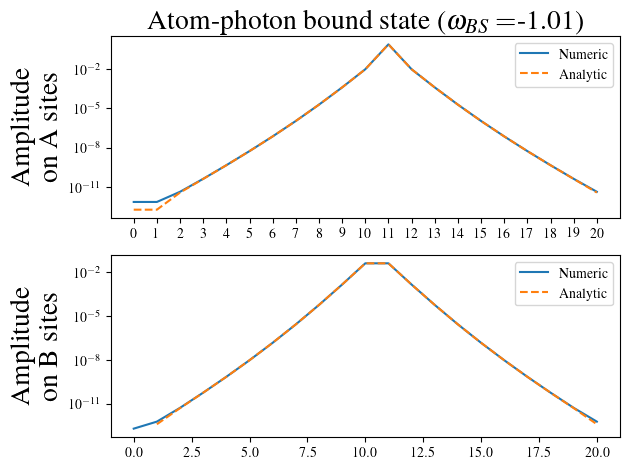

In [20]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=0,tight_layout=1)

ax[0].plot(np.arange(0,N,1),np.abs(stateA[N//2,:])**2,label="Numeric")
ax[0].plot(np.arange(0,N,1),np.abs(stateA_an[N//2+1,:])**2,label="Analytic",ls="--")

ax[1].plot(np.arange(0,N,1),np.abs(stateB_an[N//2,:])**2,label="Numeric")
ax[1].plot(np.arange(1,N,1),np.abs(stateB[N//2,1:])**2,label="Analytic",ls="--")

ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

#ax[0].set_xscale("log")
#ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
#ax[0].set_ylim(1e-10,1)

ax[1].set_yscale("log")

ax[0].legend()
ax[1].legend()
#plt.savefig("eigs&spectra/bs.png")
plt.show()

#### Dynamic in the single-excitation sector

We also study the dynamics in the single-excitation sector.

In [78]:
pop, phot = time_evol(H,0,500,500)

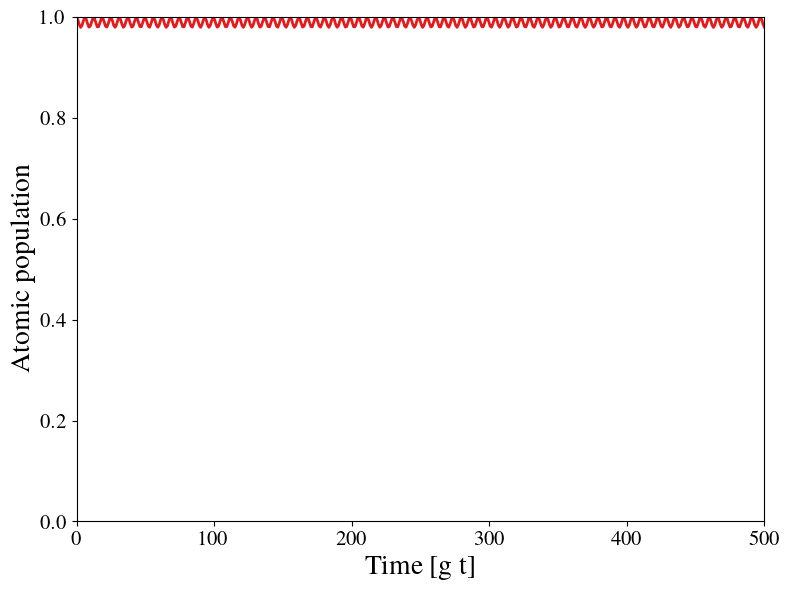

In [85]:
fig = plt.figure(figsize=(8,6),tight_layout=1)

pop_at = np.real(pop*np.conjugate(pop))
t = np.linspace(0,500,500)
plt.plot(t,pop_at,c='#e41a1c',lw=2,label="Numerics")

plt.xlabel("Time [g t]",fontsize=20)
plt.ylabel(f"Atomic population",fontsize=20)

plt.xlim(0,t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)

plt.show()

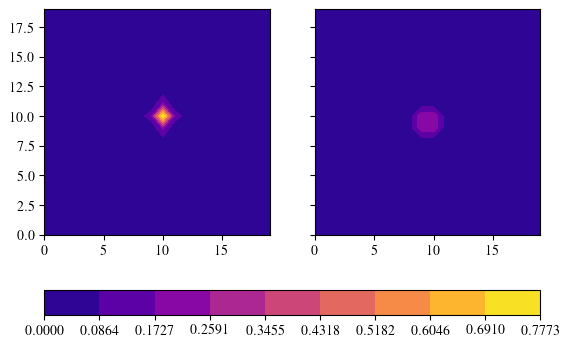

In [86]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 300

stateA = np.transpose(phot[s,:N**2].reshape(N,N))/norm(phot[s])
stateB = np.transpose(phot[s,N**2:].reshape(N,N))/norm(phot[s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)

ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

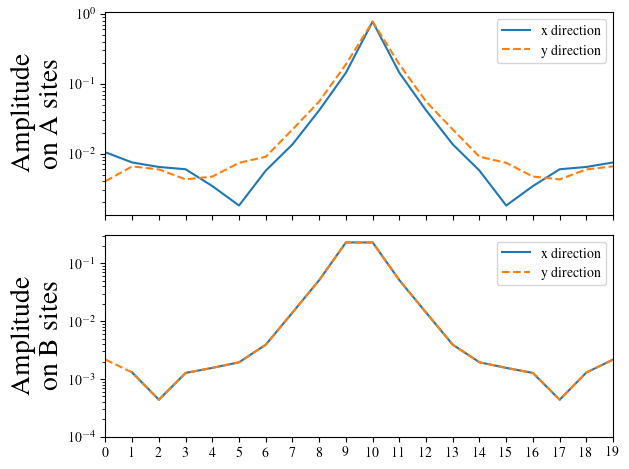

In [87]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)


ax[0].plot(np.arange(0,N,1),np.abs(stateA[N//2,:]),label="x direction")
ax[0].plot(np.arange(0,N,1),np.abs(stateA[:,N//2]),label="y direction",ls="--")

ax[1].plot(np.arange(1,N,1),np.abs(stateB[N//2,1:]),label="x direction")
ax[1].plot(np.arange(0,N,1),np.abs(stateB[:,N//2]),label="y direction",ls="--")

ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[1].set_ylim(1e-4)

ax[0].legend()
ax[1].legend()
plt.show()

### Even number of points: Band Touching

In [25]:
N = 20
J = 1

g = 0.1
om_a = -1.

Here, we define the Hamiltonian.

In [26]:
pos = (N+1)*N//2
coup = np.zeros((2*N**2,1))
coup[pos,0] -= g

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

We diagonalize the Hamiltonian.

In [27]:
eigval, eigvect = eigh(H)

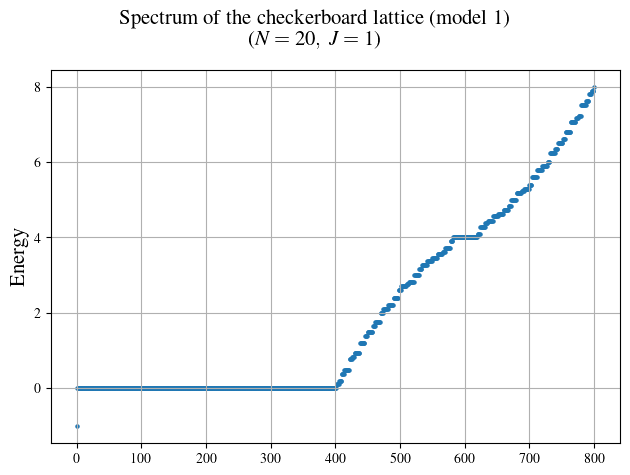

In [28]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

#plt.xlim(0,50)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

#### Atom-photon Bound state

Here, we plot the atom-photon bound states in a 2D representation.

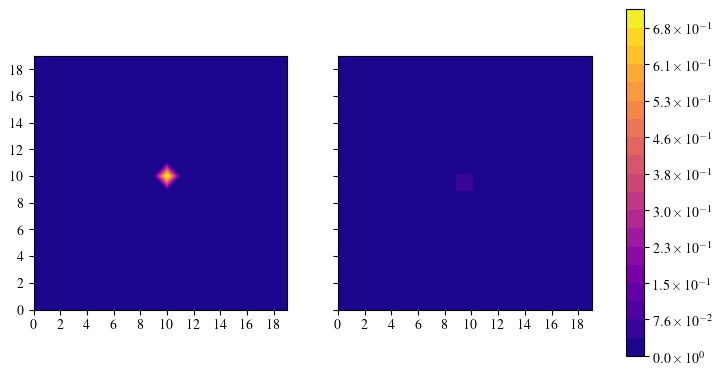

In [29]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1,figsize=(9,9))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateA)**2)
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA)**2,cmap="plasma",levels = np.linspace(vmin,vmax,20))
ax[1].contourf(Nx,Ny,np.abs(stateB)**2,cmap="plasma",levels = np.linspace(vmin,vmax,20))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)
ax[0].set_yticks(np.arange(0,N,2))
ax[0].set_xticks(np.arange(0,N,2))
ax[1].set_xticks(np.arange(0,N,2))

cbar = fig.colorbar(pcm, ax = ax[:], shrink=0.5, format=ticker.FuncFormatter(fmt))
plt.show()

Here, we plot the BS in $\texttt{log}$ scale.

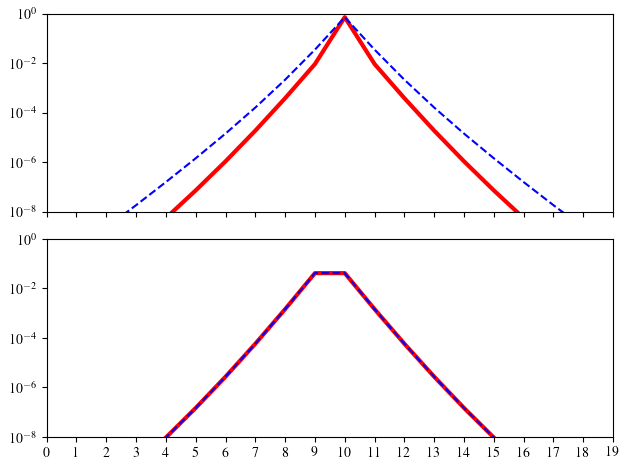

In [31]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=1,tight_layout=1)


ax[0].plot(np.arange(0,N,1),np.abs(stateA[N//2,:])**2,label="x direction",c="red",lw=3)
ax[0].plot(np.arange(0,N,1),np.abs(stateA[:,N//2])**2,label="y direction",ls="--",c="blue")

ax[1].plot(np.arange(0,N,1),np.abs(stateB[N//2,:])**2,label="x direction",c="red",lw=3)
ax[1].plot(np.arange(0,N,1),np.abs(stateB[:,N//2])**2,label="y direction",ls="--",c="blue")

#ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
#ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
#ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

#ax[0].set_xscale("log")
ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
ax[0].set_ylim(1e-8,1)
ax[1].set_ylim(1e-8,1)

ax[1].set_yscale("log")

#ax[0].legend()
#ax[1].legend()
#plt.savefig("bs_even.png")
plt.show()

We calculate the analytical profile of the BS and compare it to the numerical one. They show great accordance.

In [16]:
x = np.arange(-N//2,N//2,1)
x, y = np.meshgrid(x,x)

In [17]:
stateA_an = np.transpose(BS_A(N,eigval[s],x,y))
stateB_an = np.transpose(BS_B(N,eigval[s],x,y))

In [18]:
n = norm(np.append(np.ravel(stateA_an),np.ravel(stateB_an)))
stateA_an /= n
stateB_an /= n

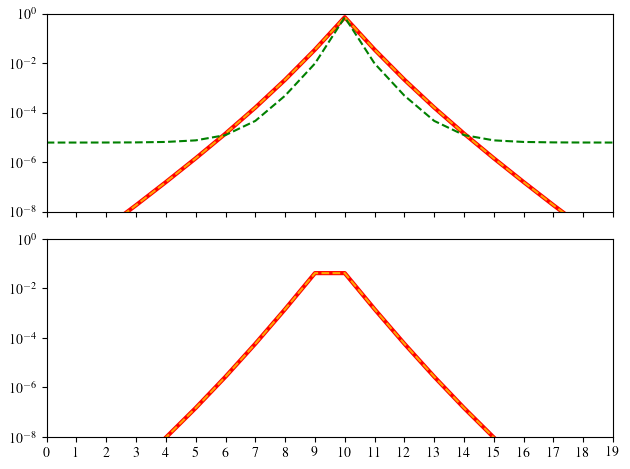

In [24]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=1,tight_layout=1)

ax[0].plot(np.arange(0,N,1),np.abs(stateA[:,N//2])**2,label="Numeric",c="red",lw=3)
ax[0].plot(np.arange(0,N,1),np.abs(stateA_an[:,N//2])**2,label="Analytic",ls="--",c="orange")
ax[0].plot(np.arange(0,N,1),np.abs(stateA_an[N//2,:]-(1/(eigval[s]*N**2)))**2,
           label="Analytic (withouth the const term)",ls="--",c="green")

ax[1].plot(np.arange(0,N,1),np.abs(stateB_an[:,N//2])**2,label="Numeric",c="red",lw=3)
ax[1].plot(np.arange(0,N,1),np.abs(stateB[:,N//2])**2,label="Analytic",ls="--",c="orange")

#ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
#ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
#ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
ax[0].set_ylim(1e-8,1)
ax[1].set_ylim(1e-8,1)

ax[1].set_yscale("log")

#ax[0].legend()
plt.savefig("bs_comp.png")
plt.show()

## Coupling to a CLS

We couple to a Compact Localized State in the form
\begin{equation}
    |\phi_{\textbf{R}}\rangle = \frac{1}{2} \Big\{ |a_{\textbf{R}}\rangle - |a_{\textbf{R} + x}\rangle + |b_{\textbf{R}}\rangle - |b_{\textbf{R} - y}\rangle \Big\}
\end{equation}

In [111]:
N = 20
J = 1

g = 0.1
om_a = -1

In [112]:
coup = np.zeros((2*N**2,1))

coup[(N+1)*N//2,0] -= g # A
coup[(N+1)*N//2 + N,0] += g # A
coup[(3*N+1)*N//2,0] -= g # B
coup[(3*N+1)*N//2 - 1,0] += g # B

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [113]:
eigval, eigvect = eigh(H)

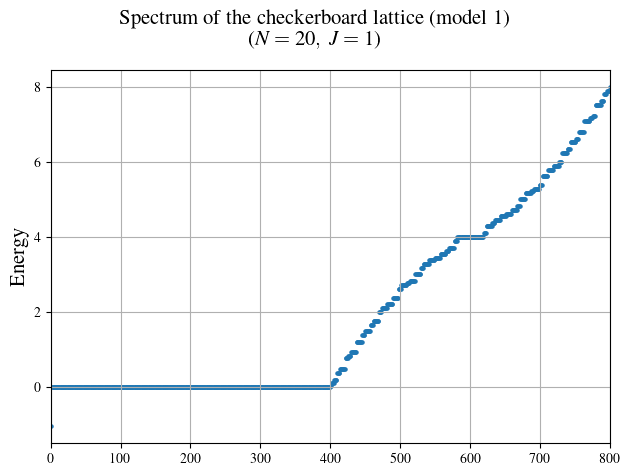

In [114]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

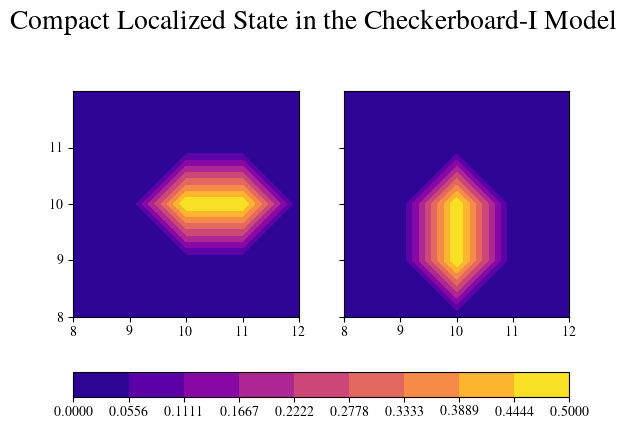

In [116]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.suptitle("Compact Localized State in the Checkerboard-I Model", fontsize=20)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateB))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(8,12)
ax[0].set_ylim(8,12)
ax[1].set_xlim(8,12)
ax[0].set_yticks(np.arange(8,12,1))

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

## Coupling to line states in the bulk

In this section, we explore the coupling with line states. A line state is a state with non-zero wave amplitude only on a $\textit{line}$ of sites, i.e. a set of sites of the same sublattice having all the same first or second component of the vector $\vec{r}$. In the following, we see how only $\textbf{Vertical-a}$ and $\textbf{Horizontal-b}$ line states are exact eigenstates of the Hamiltonian.

### Vertical-a line state

In [153]:
N = 20
J = 1

g = 0.1
om_a = -1

In [154]:
coup = np.zeros((2*N**2,1))
pos = N**2//2 #- N//2
coup[pos:pos+N,0] -= g

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [155]:
eigval, eigvect = eigh(H)

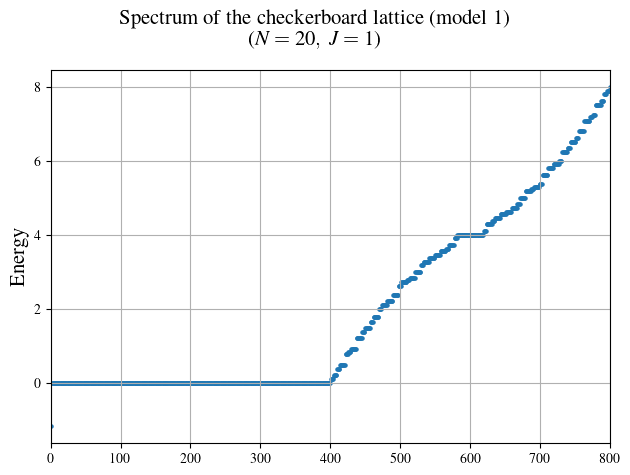

In [156]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

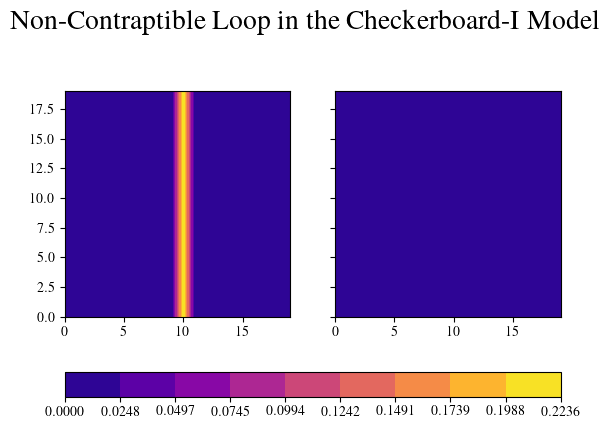

In [157]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.suptitle("Non-Contraptible Loop in the Checkerboard-I Model", fontsize=20)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

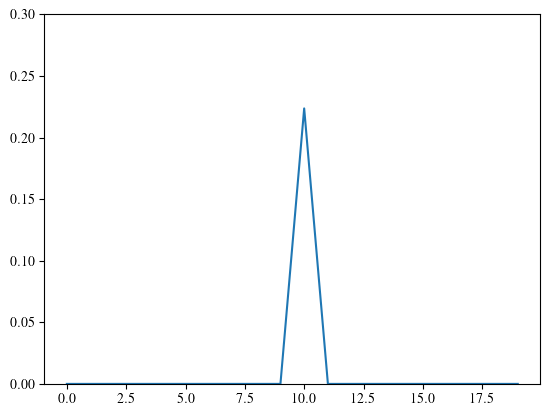

In [160]:
fig = plt.figure()

plt.plot(abs(stateA[10,:]))

plt.ylim(0,0.3)

plt.show()

### Horizontal-a line state

In [139]:
N = 20
J = 1

g = 0.1
om_a = -1

In [144]:
coup = np.zeros((2*N**2,1))
pos = N//2
coup[pos:N**2:N,0] -= g

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [145]:
eigval, eigvect = eigh(H)

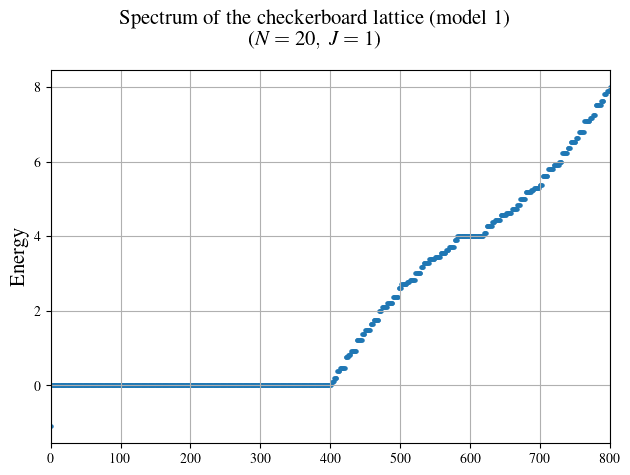

In [146]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

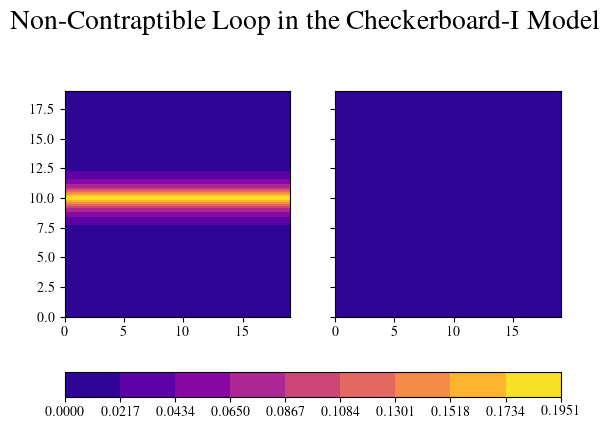

In [147]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.suptitle("Non-Contraptible Loop in the Checkerboard-I Model", fontsize=20)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

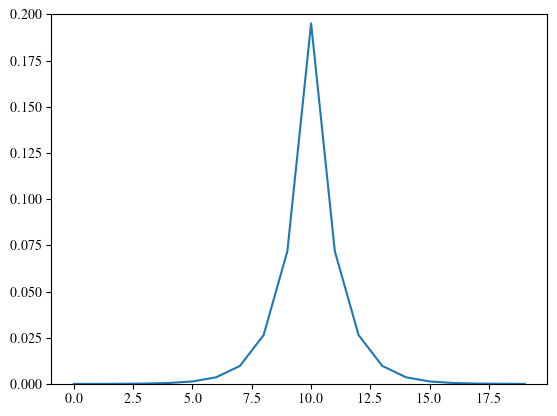

In [152]:
fig = plt.figure()

plt.plot(abs(stateA[:,10]))

plt.ylim(0,0.2)

plt.show()

### Vertical-b line state

In [161]:
N = 20
J = 1

g = 0.1
om_a = -1

In [163]:
coup = np.zeros((2*N**2,1))
pos = N**2//2 + N**2
coup[pos:pos+N,0] -= g

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [164]:
eigval, eigvect = eigh(H)

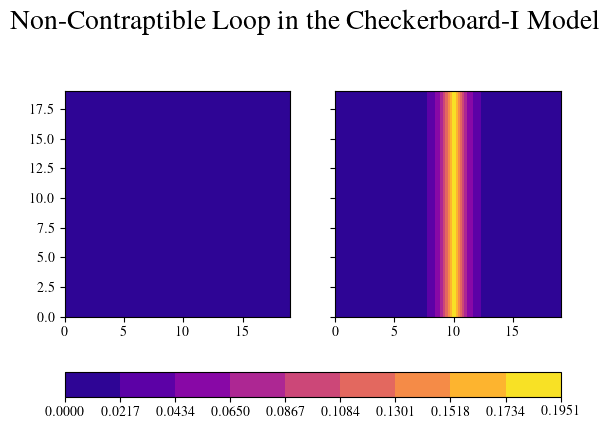

In [166]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.suptitle("Non-Contraptible Loop in the Checkerboard-I Model", fontsize=20)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateB))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

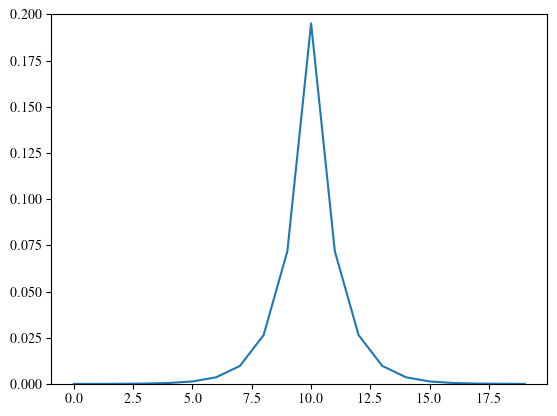

In [168]:
fig = plt.figure()

plt.plot(abs(stateB[10,:]))

plt.ylim(0,0.2)

plt.show()

### Horizontal-b line state

In [169]:
N = 20
J = 1

g = 0.1
om_a = -1

In [170]:
coup = np.zeros((2*N**2,1))
pos = N//2
coup[N**2+pos::N,0] -= g

H = np.block([
    [ HamPBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [172]:
eigval, eigvect = eigh(H)

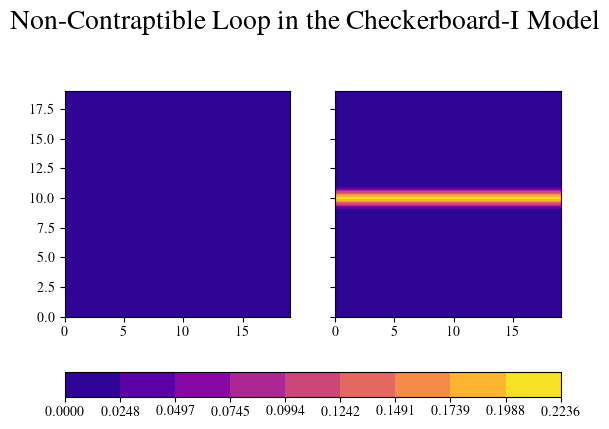

In [173]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
plt.suptitle("Non-Contraptible Loop in the Checkerboard-I Model", fontsize=20)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateB))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

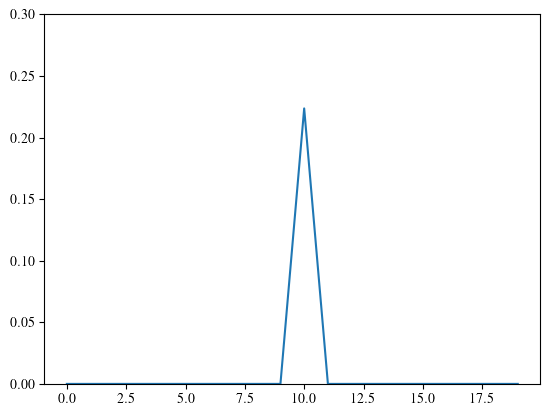

In [175]:
fig = plt.figure()

plt.plot(abs(stateB[:,10]))

plt.ylim(0,0.3)

plt.show()

# Emitter coupled to the Checkerboard-I model (Open BCs)

In [598]:
N = 20
J = 1

g = 0.1
om_a = 1

## First way to terminate the lattice

### Bulk

In [117]:
coup = np.zeros((2*N**2,1))
pos =  N*(N+1)//2
coup[pos,0] -= g

H = np.block([
    [ HamOBC(N), coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [118]:
eigval, eigvect = eigh(H)

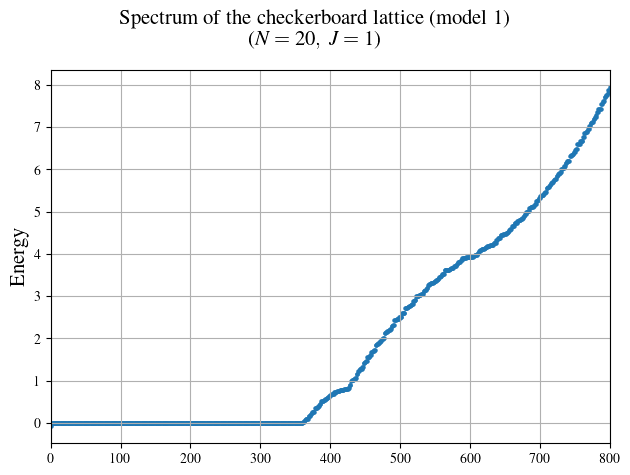

In [119]:
fig = plt.figure(tight_layout=1)

plt.suptitle("Spectrum of the checkerboard lattice (model 1)\n"+f"($N={N},\; J=1$)", fontsize=15)

plt.scatter(np.arange(2*N**2+1),eigval,s=5)

plt.xlim(0,2*N**2)
plt.ylabel("Energy", fontsize=15)
plt.grid(zorder=1)

plt.show()

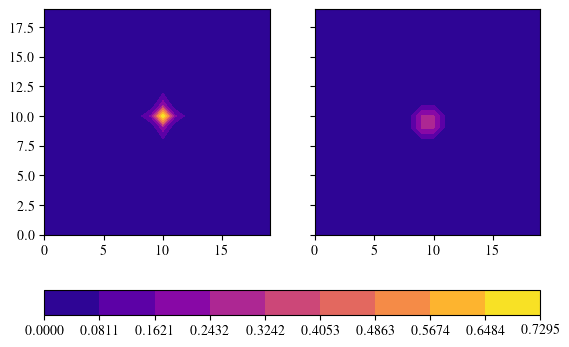

In [122]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 0

stateA = np.transpose(eigvect[:N**2,s].reshape(N,N))/norm(eigvect[:-1,s])
stateB = np.transpose(eigvect[N**2:-1,s].reshape(N,N))/norm(eigvect[:-1,s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)
ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

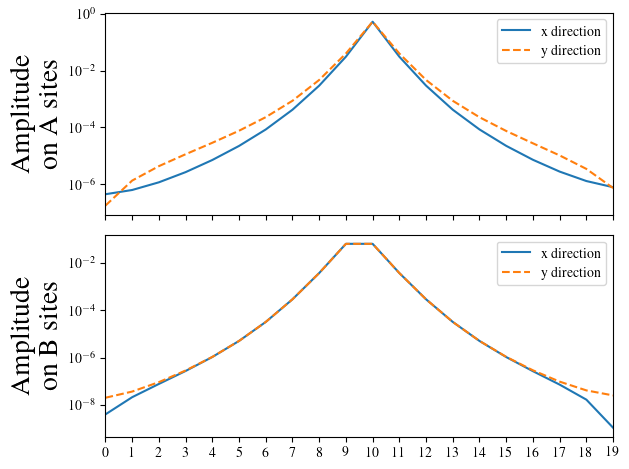

In [123]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)


ax[0].plot(np.arange(0,N,1),np.abs(stateA[N//2,:])**2,label="x direction")
ax[0].plot(np.arange(0,N,1),np.abs(stateA[:,N//2])**2,label="y direction",ls="--")

ax[1].plot(np.arange(0,N,1),np.abs(stateB[N//2,:])**2,label="x direction")
ax[1].plot(np.arange(0,N,1),np.abs(stateB[:,N//2])**2,label="y direction",ls="--")

ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)

ax[0].set_xlim(0,N-1)
ax[0].set_xticks(np.arange(0,N,1))
ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[0].legend()
ax[1].legend()
plt.show()

### Edge

In [599]:
coup = np.zeros((2*N**2,1))
pos = N**2 - N# N*(N+1)//2
coup[pos,0] -= g/np.sqrt(2)

#pos2 = N*(N-1)
#coup[pos2,0] -= g/np.sqrt(2)

H = np.block([
    [ HamOBC(N),coup],
    [np.transpose(np.conjugate(coup)),om_a]
])

In [600]:
eigval, eigvect = eigh(H)

In [601]:
t = np.linspace(0,500,100)
pop, phot = time_evol(H,0,t[-1],len(t))

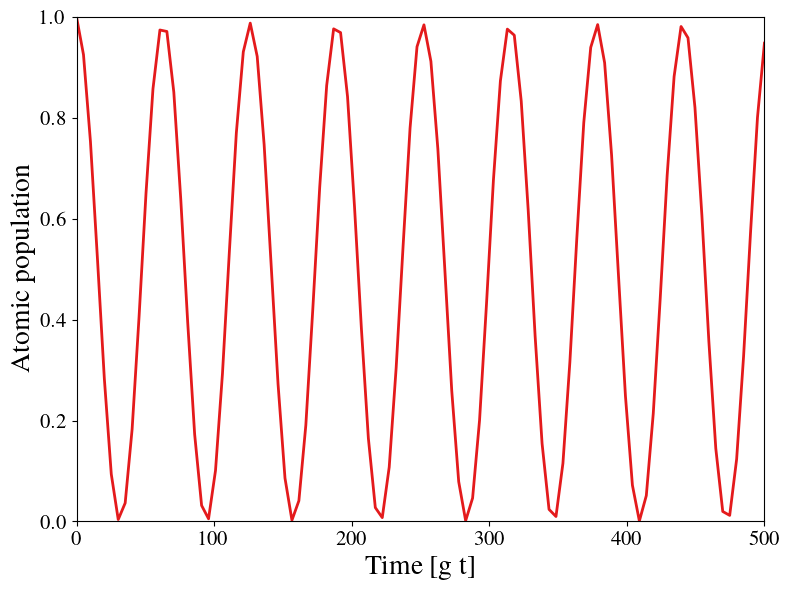

In [602]:
fig = plt.figure(figsize=(8,6),tight_layout=1)

pop_at = np.real(pop*np.conjugate(pop))

plt.plot(t,pop_at,c='#e41a1c',lw=2,label="Numerics")

plt.xlabel("Time [g t]",fontsize=20)
plt.ylabel(f"Atomic population",fontsize=20)

plt.xlim(0,t[-1])
plt.ylim(0.,1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.legend(fontsize=15)
#plt.yscale("log")

plt.show()

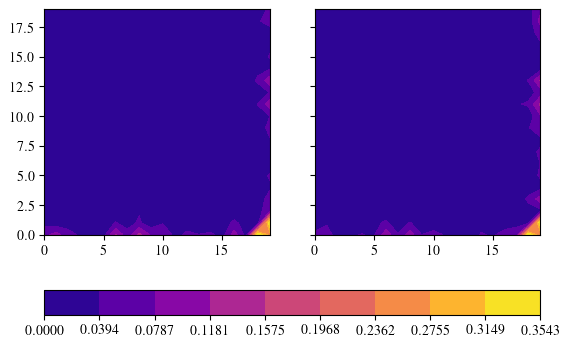

In [603]:
fig,ax = plt.subplots(nrows=1,ncols=2, sharey=1)
ax[0].set_aspect(1)
ax[1].set_aspect(1)

Nx, Ny = np.meshgrid(np.arange(0,N,1),np.arange(0,N,1))

s = 50

stateA = np.transpose(phot[s,:N**2].reshape(N,N))/norm(phot[s])
stateB = np.transpose(phot[s,N**2:].reshape(N,N))/norm(phot[s])

vmax = np.max(np.abs(stateA))
vmin = 0

pcm = ax[0].contourf(Nx,Ny,np.abs(stateA),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[1].contourf(Nx,Ny,np.abs(stateB),cmap="plasma",levels = np.linspace(vmin,vmax,10))
ax[0].set_xlim(0,N-1)
ax[0].set_ylim(0,N-1)

ax[1].set_xlim(0,N-1)

cbar = fig.colorbar(pcm,location="bottom", ax = ax[:])
plt.show()

## Second way to terminate the lattice

## Third way to terminate the lattice

In [313]:
stateA1 = stateA
stateB1 = stateB

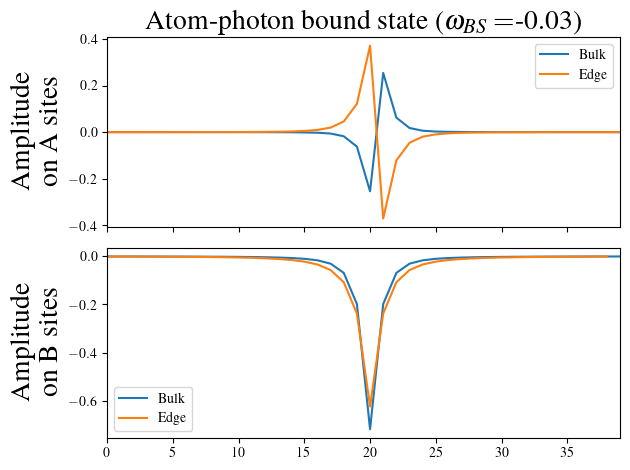

In [320]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True,tight_layout=1)

ax[0].plot(np.arange(0,N,1),stateA1[N//2,:],label="Bulk")
ax[0].plot(np.arange(0,N,1),stateA[1,:],label="Edge")

ax[1].plot(np.arange(0,N,1),stateB1[N//2,:],label="Bulk")
ax[1].plot(np.arange(0,N-1,1),stateB[0,:-1],label="Edge")


ax[0].set_title("Atom-photon bound state ($\omega_{BS} =$" + f"{eigval[s]:.2f}"+")",fontsize=20)
ax[0].set_ylabel("Amplitude \n on A sites",fontsize=20)
ax[1].set_ylabel("Amplitude \n on B sites",fontsize=20)


ax[0].set_xlim(0,N-1)
#ax[0].set_ylim(1e-4,1)
#ax[1].set_ylim(1e-4,1)
ax[0].set_xticks(np.arange(0,N,5))
#ax[0].set_yscale("log")
#ax[1].set_yscale("log")


ax[0].legend()
ax[1].legend()
#plt.savefig("eigs&spectra/comp2.png")
plt.show()